# Data Loader

In [1]:
%load_ext autoreload
%autoreload 2

# Use HuggingFace's datasets library to access the financial_phrasebank dataset
from datasets import load_dataset

import numpy as np

/home/icrl/anaconda3/envs/spacy2x/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Project 1 -- Sentiment Analysis (FiQA SA)

The FiQA SA dataset contains two sets of different instances: news headlines and social media posts. The data is available from the website of the FiQA competition: https://sites.google.com/view/fiqa/home . 

Each instance has a continuous sentiment score. Your task is to classify the posts into positive (2), negative (0) or neutral (1). First, load both the headlines and posts, along with their sentiment scores, then bin the scores into positive, negative and neutral:

In [25]:
train_files = [
    'task1_headline_ABSA_train.json',
    'task1_post_ABSA_train.json'
]

In [26]:
import json

def load_fiqa_sa_from_json(json_files):
    train_text = []
    train_labels = []

    for file in json_files:
        with open(file, 'r' ,encoding='utf-8') as handle:
            dataf = json.load(handle,)

        dataf_text = [dataf[k]["sentence"] for k in dataf.keys()]
        # print(len(dataf_text))
        train_text.extend(dataf_text)

        dataf_labels = [float(dataf[k]["info"][0]["sentiment_score"]) for k in dataf.keys()]
        # print(len(dataf_labels))
        train_labels.extend(dataf_labels)

    train_text = np.array(train_text)
    train_labels = np.array(train_labels)
    
    return train_text, train_labels


def threshold_scores(scores):
    """
    Convert sentiment scores to discrete labels.
    0 = negative.
    1 = neutral.
    2 = positive.
    """
    labels = []
    for score in scores:
        if score < -0.2:
            labels.append(0)
        elif score > 0.2:
            labels.append(2)
        else:
            labels.append(1)
            
    return np.array(labels)


all_text, all_labels = load_fiqa_sa_from_json(train_files)
    
print(f'Number of instances: {len(all_text)}')
print(f'Number of labels: {len(all_labels)}')

all_labels = threshold_scores(all_labels)
print(f'Number of negative labels: {np.sum(all_labels==0)}')
print(f'Number of neutral labels: {np.sum(all_labels==1)}')
print(f'Number of positive labels: {np.sum(all_labels==2)}')

Number of instances: 1111
Number of labels: 1111
Number of negative labels: 310
Number of neutral labels: 195
Number of positive labels: 606


Let's create a test split, which we can hold out until we have tuned our method(s).

We may also need a _validation_ set (also called 'development' set or 'devset'), which can be used to compute performance of your model when tuning hyperparameters,  optimising combinations of features, or looking at the errors your model makes before improving it. This allows you to hold out the test set (i.e., not to look at it at all when developing your method) to give a fair evaluation of the model and how well it generalises to new examples. This avoids tuning the model to specific examples in the test set. An alternative approach to validation set does not use a single fixed validation set, but instead uses [cross validation](https://scikit-learn.org/stable/modules/cross_validation.html). 

In [27]:
from sklearn.model_selection import train_test_split

# Split test data from training data
train_documents, test_documents, train_labels, test_labels = train_test_split(
    all_text, 
    all_labels, 
    test_size=0.46, 
    stratify=all_labels  # make sure the same proportion of labels is in the test set and training set
)

# Split validation data from training data
train_documents, val_documents, train_labels, val_labels = train_test_split(
    train_documents, 
    train_labels, 
    test_size=0.144, 
    stratify=train_labels  # make sure the same proportion of labels is in the test set and training set
)

print(f'Number of training instances = {len(train_documents)}')
print(f'Number of validation instances = {len(val_documents)}')
print(f'Number of test instances = {len(test_documents)}')


Number of training instances = 512
Number of validation instances = 87
Number of test instances = 512


In [28]:
print(f'What does one instance look like from the training set? \n\n{train_documents[234]}')
print(f'...and here is its corresponding label \n\n{train_labels[234]}')

What does one instance look like from the training set? 

AstraZeneca chases Acerta to secure next cancer drug winner
...and here is its corresponding label 

2


### Download and Import Libraries

In [29]:
import nltk
import re
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))
nltk.download('wordnet')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\perfect\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\perfect\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\perfect\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

### Data Cleaning

In [30]:
def preprocess_text(text):
    # Removing of URLs
    text = re.sub(r'http\S+', '', text)
    # Removing of digits
    text = re.sub(r'\d+', '', text)
    # Removing of Symbols
    text = re.sub(r'[^\w\s]', '', text)
    # Lowercase conversion
    tokens = word_tokenize(text.lower())
    # Lemmatization
    lemmatizer = WordNetLemmatizer()
    lemmas = [lemmatizer.lemmatize(token) for token in tokens]
    return [lemma for lemma in lemmas if lemma not in stop_words]

In [31]:
clean_train_documents = []
clean_test_documents = []
clean_val_documents = []
# Cleaning of train data
for text in train_documents:
    clean_train_documents.append(preprocess_text(text))
# Cleaning of test data
for text in test_documents:
    clean_test_documents.append(preprocess_text(text))
# Cleaning of validation data
for text in val_documents:
    clean_val_documents.append(preprocess_text(text))

### Data Preprocessing

In [32]:
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer()
# Preprocess text data
x_train = vectorizer.fit_transform([" ".join(i) for i in clean_train_documents])
x_val = vectorizer.transform([" ".join(i) for i in clean_val_documents])
x_test = vectorizer.transform([" ".join(i) for i in clean_test_documents])

### Model traning
* Naive Bayes
* Logistic Regression

#### Naive Bayes

In [33]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
# Train machine learning algorithm
clf = MultinomialNB()
clf.fit(x_train, train_labels)

MultinomialNB()

In [34]:
# Evaluate model on test set
clf_pred = clf.predict(x_test)
clf_acc = 100 * round(accuracy_score(test_labels, clf_pred), 2)
print('Accuracy: ',clf_acc, '%')
print(f'Precision: {precision_score(test_labels, clf_pred, average="weighted")}')
print(f'Recall: {recall_score(test_labels, clf_pred, average="weighted")}')
print(f'F1 score: {f1_score(test_labels, clf_pred, average="weighted")}')

Accuracy:  66.0 %
Precision: 0.6461214322654251
Recall: 0.66015625
F1 score: 0.6249731432963455


#### Logistic Regression

In [35]:
from sklearn.linear_model import LogisticRegression
# Train machine learning algorithm
lg = LogisticRegression()
lg.fit(x_train, train_labels)

LogisticRegression()

In [36]:
# Evaluate model on test set
lg_pred = lg.predict(x_test)
lg_acc = 100 * round(accuracy_score(test_labels, lg_pred), 2)
print('Accuracy: ',lg_acc, '%')
print(f'Precision: {precision_score(test_labels, lg_pred, average="weighted")}')
print(f'Recall: {recall_score(test_labels, lg_pred, average="weighted")}')
print(f'F1 score: {f1_score(test_labels, lg_pred, average="weighted")}')

Accuracy:  65.0 %
Precision: 0.6368000028531582
Recall: 0.650390625
F1 score: 0.6164317161240344


### Results

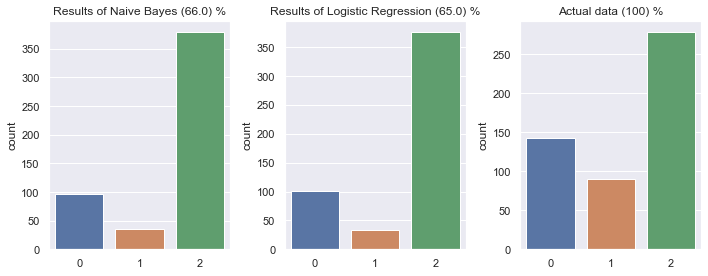

In [37]:
import warnings
import seaborn as sns
warnings.simplefilter("ignore")
import matplotlib.pyplot as plt
plt.figure(figsize=(10,4))
sns.set()
plt.subplot(131)
plt.title(f'Results of Naive Bayes ({clf_acc}) %')
sns.countplot(clf_pred)
plt.subplot(132)
plt.title(f'Results of Logistic Regression ({lg_acc}) %')
sns.countplot(lg_pred)
plt.subplot(133)
plt.title('Actual data (100) %')
sns.countplot(test_labels)
plt.tight_layout()

### Extracting Topics

In [105]:
# Importing libraries
from wordcloud import WordCloud

# Extract the positive and Negative data
positive_list = [clean_test_documents[i] for i in range(len(train_labels)) if train_labels[i] == 0]
negative_list = [clean_test_documents[i] for i in range(len(train_labels)) if train_labels[i] == 2]

# Converting both list into strings
positive_data = ' '.join([element1 for pos in positive_list for element1 in pos])
negative_data = ' '.join([element2 for neg in negative_list for element2 in neg])


In [106]:
# Generating wordcloud for postive sentiments
wordcloud1 = WordCloud(width = 800, height = 800, 
                background_color ='white', 
                stopwords = stopwords, 
                min_font_size = 10).generate(positive_data)

# Generating wordcloud for negative sentiments
wordcloud2 = WordCloud(width = 800, height = 800, 
                background_color ='white', 
                stopwords = stopwords, 
                min_font_size = 10).generate(negative_data)

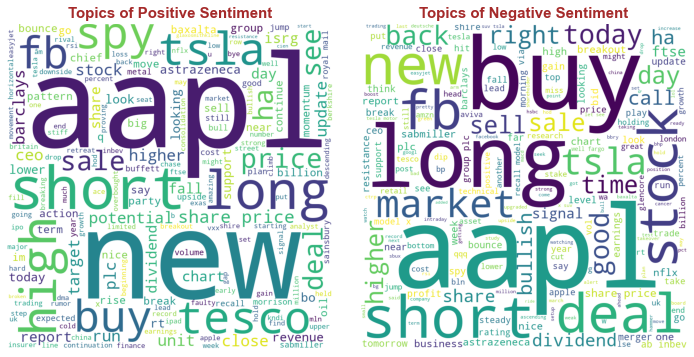

In [108]:
# visualization of Topics
plt.figure(figsize = (10, 5), facecolor = None) 
plt.subplot(121)
plt.title('Topics of Positive Sentiment',fontsize = 15, fontweight = 'bold', color = 'brown')
plt.imshow(wordcloud1)
plt.axis("off") 
plt.subplot(122)
plt.title('Topics of Negative Sentiment',fontsize = 15, fontweight = 'bold', color = 'brown')
plt.imshow(wordcloud2) 
plt.axis("off") 
plt.tight_layout() 

# Project 2: BIONLP 2004

This dataset contains abstracts from MEDLINE, a database containing journal articles from fields including medicine and pharmacy. 
The data was collected by searching for the terms ‘human’, ‘blood cells’ and ‘transcription factors’, and then annotated with five entity types: DNA, protein, cell type, cell line, RNA. 

More information in the paper: https://aclanthology.org/W04-1213.pdf

The data can be downloaded from HuggingFace: https://huggingface.co/datasets/tner/bionlp2004

In [13]:
# !python -m spacy download en

In [14]:
# !pip install spacy[en]

In [15]:
# !pip uninstall en_core_web_sm

In [16]:
# !python -m spacy download en_core_web_sm

### Importing Libraries

In [5]:
import spacy
from pathlib import Path
print(spacy.__version__)
import spacy
import random
from spacy.util import minibatch, compounding
import warnings
warnings.filterwarnings('ignore')

2.3.9


In [6]:
dataset = load_dataset(
    "tner/bionlp2004", 
    cache_dir='./data_cache'
)

print(f'The dataset is a dictionary with {len(dataset)} splits: \n\n{dataset}')

Found cached dataset bionlp2004 (/home/icrl/Downloads/Sentiment/Sentiment classification/data_cache/tner___bionlp2004/bionlp2004/1.0.0/9f41d3f0270b773c2762dee333ae36c29331e2216114a57081f77639fdb5e904)
100%|████████████████████████████████████████████| 3/3 [00:00<00:00, 550.65it/s]

The dataset is a dictionary with 3 splits: 

DatasetDict({
    train: Dataset({
        features: ['tokens', 'tags'],
        num_rows: 16619
    })
    validation: Dataset({
        features: ['tokens', 'tags'],
        num_rows: 1927
    })
    test: Dataset({
        features: ['tokens', 'tags'],
        num_rows: 3856
    })
})


The dataset is already split into train, validation and test. It may be useful to reformat the DatasetDict object into lists of sentences and tags:

In [7]:
train_sentences_ner = [item['tokens'] for item in dataset['train']]
train_sentences = [' '.join(sentence) for sentence in train_sentences_ner]
train_labels_ner = [[str(tag) for tag in item['tags']] for item in dataset['train']]

val_sentences_ner = [item['tokens'] for item in dataset['validation']]
val_sentences = [' '.join(sentence) for sentence in val_sentences_ner]
val_labels_ner = [[str(tag) for tag in item['tags']] for item in dataset['validation']]

test_sentences_ner = [item['tokens'] for item in dataset['test']]
test_sentences = [' '.join(sentence) for sentence in test_sentences_ner]
test_labels_ner = [[str(tag) for tag in item['tags']] for item in dataset['test']]

In [8]:
print(f'Number of training sentences = {len(train_sentences_ner)}')
print(f'Number of validation sentences = {len(val_sentences_ner)}')
print(f'Number of test sentences = {len(test_sentences_ner)}')

Number of training sentences = 16619
Number of validation sentences = 1927
Number of test sentences = 3856


In [9]:
print(f'What does one instance look like from the training set? \n\n{train_sentences_ner[234]}')
print(f'...and here is its corresponding label \n\n{train_labels_ner[234]}')

What does one instance look like from the training set? 

['Hence', ',', 'PPAR', 'can', 'positively', 'or', 'negatively', 'influence', 'TH', 'action', 'depending', 'on', 'TRE', 'structure', 'and', 'THR', 'isotype', '.']
...and here is its corresponding label 

['0', '0', '3', '0', '0', '0', '0', '0', '0', '0', '0', '0', '1', '0', '0', '3', '4', '0']


In [10]:
print(f'Number of unique labels: {np.unique(np.concatenate(train_labels_ner))}')

Number of unique labels: ['0' '1' '10' '2' '3' '4' '5' '6' '7' '8' '9']


These are the tags used to annotate the entities:

In [11]:
# mapping from labels to the tags

id2label = {
    "O": 0,
    "B-DNA": 1,
    "I-DNA": 2,
    "B-protein": 3,
    "I-protein": 4,
    "B-cell_type": 5,
    "I-cell_type": 6,
    "B-cell_line": 7,
    "I-cell_line": 8,
    "B-RNA": 9,
    "I-RNA": 10
}

label2id = {v:k for k, v in id2label.items()}
print(label2id)

{0: 'O', 1: 'B-DNA', 2: 'I-DNA', 3: 'B-protein', 4: 'I-protein', 5: 'B-cell_type', 6: 'I-cell_type', 7: 'B-cell_line', 8: 'I-cell_line', 9: 'B-RNA', 10: 'I-RNA'}


### Data Generation

In [12]:
train_data = []
for sentence, labels in zip(train_sentences, train_labels_ner):
    entities_list = []
    tags_dict = {}
    last_index = 0
    flag = False
    for word, label in zip(sentence.split(' '), labels):
        if label != '0':
            start_index = sentence.find(word, last_index)
            end_index = start_index + len(word)
            label_key = [k for k, v in id2label.items() if v == int(label)][0]
            annotation = (start_index, end_index, label_key)
            entities_list.append(annotation)
            last_index = end_index
            flag =True
    
    if flag:
        tags_dict['entities'] = entities_list
        train_example = (sentence, tags_dict)
        train_data.append(train_example)

### Loading Model

In [13]:

nlp = spacy.load("en_core_web_sm")
language = nlp.meta["lang"]

data_path = Path(spacy.__file__).parent / "data"
lookups_path = data_path / language / f"{language}_lookups.json"

# print(lookups_path)

### Model Traning

In [14]:
# Define the function to train the model
def train_model(train_data, iterations):

    # Load the spaCy model with the path to the lookup tables
    nlp = spacy.load("en_core_web_sm", exclude=["parser", "ner"])

    if "ner" not in nlp.pipe_names:
#         ner = nlp.create_pipe("ner")
        nlp.add_pipe("ner", last=True)
        ner = nlp.get_pipe("ner")
    else:
        ner = nlp.get_pipe("ner")

    for _, annotations in train_data:
        for ent in annotations.get("entities"):
            ner.add_label(ent[2])
    
    
    other_pipes = [pipe for pipe in nlp.pipe_names if pipe != "ner"]
    with nlp.disable_pipes(*other_pipes):
        optimizer = nlp.begin_training()
        for i in range(iterations):
            random.shuffle(train_data)
            losses = {}
            batches = minibatch(train_data, size=compounding(4.0, 32.0, 1.001))
            for batch in batches:
                texts, annotations = zip(*batch)
                nlp.update(texts, annotations, sgd=optimizer, drop=0.35, losses=losses)
            print("Losses", losses)
    return nlp


# Train the model
model = train_model(train_data, iterations=50)


Losses {'ner': 264393.2225523945}
Losses {'ner': 254870.44671463687}
Losses {'ner': 251015.51417301386}
Losses {'ner': 248660.86357824318}
Losses {'ner': 247184.9399635396}
Losses {'ner': 245071.96233393252}
Losses {'ner': 245406.5544329863}
Losses {'ner': 244486.23176047555}
Losses {'ner': 243412.46029316552}
Losses {'ner': 243278.15557043348}
Losses {'ner': 243087.03054461256}
Losses {'ner': 241936.83221693803}
Losses {'ner': 241908.067699873}
Losses {'ner': 241535.84431976348}
Losses {'ner': 241188.42511029815}
Losses {'ner': 241313.15830261444}
Losses {'ner': 240714.22997995032}
Losses {'ner': 240468.14271946577}
Losses {'ner': 241124.65496863355}
Losses {'ner': 241304.13699557004}
Losses {'ner': 241847.15498369397}
Losses {'ner': 241525.35773382802}
Losses {'ner': 239642.380134453}
Losses {'ner': 239767.60763517767}
Losses {'ner': 240658.21785331657}
Losses {'ner': 238884.40910670767}
Losses {'ner': 240419.47267126362}
Losses {'ner': 239981.55593053252}
Losses {'ner': 239394.57103

In [15]:
# saving a model
model.to_disk("my_model")

### Testing

In [17]:
# Test the model
model = spacy.load("my_model")
for samples in test_sentences:
    doc = model(samples)
    print("\nEntities", [(ent.text, ent.label_) for ent in doc.ents])


Entities [('glucocorticoid', 'B-protein'), ('receptors', 'I-protein'), ('lymphocytes', 'B-cell_type')]

Entities [('glucocorticoid', 'B-protein'), ('receptors', 'I-protein'), ('GR', 'B-protein'), ('peripheral', 'B-cell_type'), ('blood', 'I-cell_type'), ('lymphocytes', 'I-cell_type')]

Entities [('lymphocytes', 'B-cell_type'), ('GR', 'B-protein'), ('control', 'B-cell_type'), ('cells', 'I-cell_type')]

Entities [('GR', 'B-protein')]

Entities [('lymphocytes', 'B-cell_type'), ('GR', 'B-protein')]

Entities [('1', 'B-protein'), (',', 'I-protein'), ('25-Dihydroxyvitamin', 'I-protein'), ('D3', 'I-protein'), ('receptors', 'I-protein'), ('lymphocytes', 'B-cell_type'), ('T-', 'B-cell_type'), ('and', 'I-cell_type'), ('B-lymphocyte', 'I-cell_type')]

Entities [('lymphocytes', 'B-cell_type')]

Entities [('lymphocytes', 'B-cell_type')]

Entities [('T', 'B-cell_type'), ('lymphocytes', 'I-cell_type')]

Entities []

Entities [('lymphocytes', 'B-cell_type')]

Entities [('T', 'B-cell_type'), ('lymphocy


Entities [('glucocorticoid', 'B-protein'), ('receptor', 'I-protein'), ('glucocorticoid', 'B-protein'), ('receptor', 'I-protein'), ('polymorphonuclear', 'B-cell_type'), ('leukocytes', 'I-cell_type'), ('lymphocytes', 'B-cell_type')]

Entities [('polymorphonuclear', 'B-cell_type'), ('leukocytes', 'I-cell_type'), ('glucocorticoid', 'B-protein'), ('receptor', 'I-protein'), ('polymorphonuclear', 'B-cell_type'), ('leukocytes', 'I-cell_type'), ('lymphocytes', 'B-cell_type'), ('glucocorticoid', 'B-protein'), ('receptor', 'I-protein'), ('lymphocytes', 'B-cell_type')]

Entities [('glucocorticoid', 'B-protein'), ('receptor', 'I-protein'), ('peripheral', 'B-cell_type'), ('blood', 'I-cell_type'), ('leukocytes', 'I-cell_type')]

Entities [('Estradiol', 'B-protein'), ('receptors', 'I-protein'), ('peripheral', 'B-cell_type'), ('blood', 'I-cell_type'), ('mononuclear', 'I-cell_type'), ('cells', 'I-cell_type'), ('interferon-alpha', 'B-protein')]

Entities [('Estradiol', 'B-protein'), ('receptors', 'I-pro


Entities [('pure', 'B-protein'), ('B', 'I-protein'), ('cell-specific', 'I-protein'), ('factor', 'I-protein'), ('affinity-purified', 'B-protein'), ('ubiquitous', 'I-protein'), ('factor', 'I-protein')]

Entities [('B', 'B-protein'), ('cell-specific', 'I-protein'), ('octamer-binding', 'I-protein'), ('factor', 'I-protein'), ('kappa', 'B-DNA'), ('light', 'I-DNA'), ('chain', 'I-DNA'), ('promoter', 'I-DNA'), ('B', 'B-protein'), ('cell-specific', 'I-protein'), ('transcription', 'I-protein'), ('factor', 'I-protein')]

Entities [('ubiquitous', 'B-protein'), ('and', 'I-DNA'), ('B', 'I-DNA'), ('cell-specific', 'I-protein'), ('octamer-binding', 'I-protein'), ('factors', 'I-protein'), ('B', 'B-cell_type'), ('cell', 'I-cell_type'), ('kappa', 'B-DNA'), ('promoter', 'I-DNA')]

Entities [('glucocorticoid-receptor', 'B-protein'), ('complex', 'I-protein'), ('cultured', 'B-cell_line'), ('skin', 'I-cell_line'), ('fibroblasts', 'I-cell_line')]

Entities []

Entities [('plasma', 'I-protein'), ('ACTH', 'I-pro


Entities []

Entities [('World', 'I-protein'), ('primate', 'I-protein'), ('species', 'I-protein')]

Entities []

Entities [('circulating', 'B-cell_type'), ('mononuclear', 'I-cell_type'), ('lymphocytes', 'I-cell_type'), ('cultured', 'B-cell_line'), ('skin', 'I-cell_line'), ('fibroblasts', 'I-cell_line'), ('glucocorticoid', 'B-protein'), ('receptors', 'I-protein')]

Entities [('B-lymphocytes', 'B-cell_type'), ('glucocorticoid', 'B-protein'), ('receptor', 'I-protein')]

Entities []

Entities []

Entities []

Entities []

Entities [('cytosolic', 'B-protein'), ('hormone-receptor-complexes', 'I-protein'), ('unactivated', 'B-protein'), ('receptor', 'I-protein'), ('complexes', 'I-protein'), ('intact', 'B-cell_type'), ('cells', 'I-cell_type')]

Entities []

Entities [('intra-adrenal', 'B-protein'), ('mineralocorticoid', 'I-protein'), ('receptor', 'I-protein')]

Entities [('aldosterone', 'B-protein'), ('receptor', 'I-protein')]

Entities []

Entities [('erythroid', 'B-protein'), ('Kruppel-like'


Entities [('NF-kappa', 'B-protein'), ('B', 'I-protein'), ('AP-1', 'B-protein'), ('FasL', 'B-protein')]

Entities [('granulocyte-colony-stimulating', 'B-protein'), ('factor', 'I-protein')]

Entities [('granulocyte-colony-stimulating', 'B-protein'), ('factor', 'I-protein'), ('G-CSF', 'B-protein'), ('cultured', 'B-cell_line'), ('cells', 'I-cell_line')]

Entities [('G-CSF', 'B-protein'), ('multiple', 'B-protein'), ('signaling', 'I-protein'), ('proteins', 'I-protein'), ('primary', 'B-cell_type'), ('murine', 'I-cell_type'), ('bone', 'I-cell_type'), ('marrow', 'I-cell_type'), ('cells', 'I-cell_type'), ('granulocytic', 'B-cell_line'), ('colonies', 'I-cell_line')]

Entities [('peripheral', 'B-cell_type'), ('blood', 'I-cell_type'), ('neutrophil', 'I-cell_type')]

Entities [('extracellular', 'B-protein'), ('domain', 'I-protein'), ('murine', 'B-protein'), ('G-CSF', 'I-protein'), ('receptor', 'I-protein'), ('oligomerizing', 'B-protein'), ('receptor', 'I-protein'), ('chains', 'I-protein')]

Entitie


Entities [('RAEB', 'B-DNA'), (',', 'I-DNA'), ('RAEB-t', 'I-DNA')]

Entities [('granulocytes', 'B-cell_type'), ('monocytes', 'B-cell_type')]

Entities [('CD34+', 'B-cell_type'), ('progenitor', 'I-cell_type'), ('cells', 'I-cell_type')]

Entities [('CD3+', 'B-cell_type'), ('T', 'I-cell_type'), ('lymphocytes', 'I-cell_type')]

Entities [('X-chromosome', 'B-DNA'), ('CD19+', 'B-cell_type'), ('B', 'I-cell_type'), ('cells', 'I-cell_type'), ('CD3+', 'B-cell_type'), ('T', 'I-cell_type'), ('cells', 'I-cell_type'), ('monoclonal', 'B-cell_type'), ('B', 'I-cell_type'), ('and', 'I-cell_type'), ('polyclonal', 'I-cell_type'), ('T', 'I-cell_type'), ('lymphocytes', 'I-cell_type'), ('myeloid', 'B-cell_type'), ('and', 'I-cell_type'), ('B-lymphoid', 'I-cell_type'), ('lineages', 'I-cell_type')]

Entities [('mature', 'B-cell_type'), ('myeloid', 'I-cell_type'), ('cells', 'I-cell_type'), ('immature', 'B-cell_type'), ('and', 'I-cell_type'), ('committed', 'I-cell_type'), ('marrow', 'I-cell_type'), ('progenitors'


Entities [('adherent', 'B-cell_type'), ('leukocytes', 'I-cell_type'), ('endothelial', 'B-cell_type'), ('cells', 'I-cell_type')]

Entities [('IL-1beta', 'B-protein')]

Entities [('rolling', 'B-cell_type'), ('cells', 'I-cell_type')]

Entities [('leukocytes', 'B-cell_type'), ('IL-1beta-stimulated', 'B-cell_type'), ('endothelial', 'I-cell_line'), ('cells', 'I-cell_line'), ('leukocytes', 'B-cell_type')]

Entities [('leukocytes', 'B-cell_type'), ('IL-1beta-treated', 'B-cell_line'), ('endothelial', 'I-cell_line'), ('cells', 'I-cell_line'), ('leukocytes', 'B-cell_type'), ('IL1beta', 'B-protein')]

Entities [('E-selectin', 'B-protein'), ('intercellular', 'B-protein'), ('cell', 'I-protein'), ('adhesion', 'I-protein'), ('molecule-1', 'I-protein'), ('vascular', 'B-protein'), ('cell', 'I-protein'), ('adhesion', 'I-protein'), ('molecule-1', 'I-protein'), ('endothelial', 'B-cell_type'), ('cells', 'I-cell_type'), ('mouse', 'B-protein'), ('mAb', 'I-protein')]

Entities [('E-selectin', 'B-protein'), ('


Entities [('TNF', 'B-protein'), ('IL-8', 'B-protein')]

Entities [('HepG2', 'B-cell_type'), ('cells', 'I-cell_type')]

Entities [('TNF', 'B-protein'), ('MnSOD', 'B-protein'), ('cultures', 'I-cell_line')]

Entities [('MnSOD', 'B-protein'), ('MnSOD', 'B-protein'), ('TNF', 'B-protein')]

Entities [('MnSOD', 'B-protein'), ('TNF', 'B-protein')]

Entities [('transfected', 'B-cell_line'), ('liver', 'I-cell_line'), ('cell', 'I-cell_line'), ('lines', 'I-cell_line'), ('injurious', 'B-protein'), ('factors', 'I-protein'), ('protective', 'B-protein')]

Entities [('Egr-1', 'B-protein')]

Entities []

Entities [('fibrin', 'B-protein'), ('tissue', 'B-protein'), ('factor', 'I-protein'), ('oxygen-deprived', 'B-cell_type'), ('mononuclear', 'I-cell_type'), ('phagocytes', 'I-cell_type'), ('MPs', 'B-protein')]

Entities [('transcription', 'B-protein'), ('factor', 'I-protein'), ('gene', 'I-protein'), ('product', 'I-protein'), ('Egr-1', 'B-protein'), ('tissue', 'B-protein'), ('factor', 'I-protein')]

Entitie


Entities [('MO', 'B-cell_type'), ('dendritic', 'B-cell_type'), ('cells', 'I-cell_type')]

Entities [('Transcription', 'B-protein'), ('factor', 'I-protein'), ('B-cell-specific', 'I-protein'), ('activator', 'I-protein'), ('protein', 'I-protein'), ('BSAP', 'B-protein'), ('B', 'B-cell_type'), ('cells', 'I-cell_type'), ('B-cell', 'B-cell_type'), ('lymphomas', 'I-cell_type')]

Entities [('paired', 'B-DNA'), ('box', 'I-DNA'), ('gene', 'B-DNA'), ('PAX-5', 'I-DNA'), ('transcription', 'B-protein'), ('factor', 'I-protein'), ('BSAP', 'B-protein'), ('B-cell-specific', 'B-protein'), ('activator', 'I-protein'), ('protein', 'I-protein')]

Entities [('BSAP', 'B-protein')]

Entities [('cell', 'B-cell_line'), ('lines', 'I-cell_line')]

Entities [('BSAP', 'B-protein'), ('mantle', 'B-cell_type'), ('zone', 'I-cell_type'), ('B', 'I-cell_type'), ('cells', 'I-cell_type'), ('follicular', 'B-cell_type'), ('center', 'I-cell_type'), ('B', 'I-cell_type'), ('cells', 'I-cell_type'), ('T-cell-rich', 'B-protein'), ('z


Entities [('NF-kappaB', 'B-protein'), ('CD45RA+', 'B-cell_type'), ('cells', 'I-cell_type'), ('CD45RO+', 'B-cell_type'), ('cells', 'I-cell_type')]

Entities [('nuclear', 'B-protein'), ('c-Rel', 'I-protein'), ('protein', 'I-protein'), ('anti-CD3+anti-CD28', 'B-protein'), ('c-Rel', 'B-protein'), ('CD45RA+', 'B-cell_type'), ('cells', 'I-cell_type')]

Entities [('cytoplasmic', 'B-protein'), ('inhibitor', 'I-protein'), ('IkappaBalpha', 'B-protein'), ('anti-CD3+anti-CD28', 'B-protein'), ('CD45RA+', 'B-cell_type'), ('cells', 'I-cell_type'), ('CD45RO+', 'B-cell_type'), ('cells', 'I-cell_type')]

Entities [('CD28', 'B-protein'), ('CD45RA+', 'B-cell_type'), ('and', 'I-cell_type'), ('CD45RO+', 'I-cell_type'), ('cells', 'I-cell_type')]

Entities [('CD45RA+', 'B-cell_type'), ('cells', 'I-cell_type')]

Entities [('CD45RA+', 'B-cell_type'), ('and', 'I-cell_type'), ('CD45RO+', 'I-cell_type'), ('T', 'I-cell_type'), ('lymphocytes', 'I-cell_type')]

Entities []

Entities []

Entities []

Entities [('Lymp


Entities [('HSBP1', 'B-protein'), ('homologous', 'B-protein'), ('Caenorhabditis', 'I-protein'), ('elegans', 'I-protein'), ('protein', 'I-protein'), ('muscle', 'B-cell_type'), ('cells', 'I-cell_type'), ('heat', 'B-DNA'), ('shock', 'I-DNA'), ('promoter-reporter', 'I-DNA'), ('construct', 'I-DNA')]

Entities [('HSBP1', 'B-protein'), ('HSBP1', 'B-protein')]

Entities [('cytokine', 'B-DNA'), ('gene', 'I-DNA')]

Entities [('cytokine', 'B-DNA'), ('gene', 'I-DNA'), ('proximal', 'B-DNA'), ('promoters', 'I-DNA')]

Entities [('distal', 'B-DNA'), ('elements', 'I-DNA'), ('cytokine', 'B-DNA'), ('gene', 'I-DNA'), ('chromatin', 'B-DNA'), ('cytokine', 'B-DNA'), ('gene', 'I-DNA'), ('loci', 'I-DNA')]

Entities [('cytokine', 'B-DNA'), ('genes', 'I-DNA')]

Entities [('signaling', 'B-protein'), ('complex', 'I-protein'), ('Ca2+', 'B-protein'), ('protein', 'I-protein'), ('kinase', 'I-protein'), ('IV', 'I-protein'), ('protein', 'B-protein'), ('phosphatase', 'I-protein'), ('2A', 'I-protein')]

Entities [('T', '


Entities [('adhesion', 'B-protein'), ('molecule', 'I-protein'), ('human', 'B-cell_type'), ('endothelial', 'I-cell_type'), ('cells', 'I-cell_type'), ('ECV', 'B-protein'), ('human', 'B-cell_line'), ('Jurkat', 'I-cell_line'), ('T', 'I-cell_line'), ('cells', 'I-cell_line'), ('ECV', 'B-cell_type'), ('cells', 'I-cell_type')]

Entities [('adhesion', 'B-protein'), ('molecule', 'I-protein')]

Entities [('ICAM-1', 'B-protein'), ('VCAM-1', 'B-protein'), ('Jurkat', 'B-cell_line'), ('T-cells', 'I-cell_line'), ('ECV', 'B-cell_type'), ('cells', 'I-cell_type')]

Entities [('ICAM-1', 'B-protein'), ('VCAM-1', 'B-protein'), ('PMA-activated', 'B-cell_type'), ('untreated', 'I-cell_type'), ('cells', 'I-cell_type')]

Entities [('PMA-induced', 'B-protein'), ('adhesion', 'I-protein'), ('molecule', 'I-protein')]

Entities [('adhesion', 'B-protein'), ('molecule', 'I-protein'), ('NF-kappaB', 'B-protein')]

Entities [('Protein', 'B-protein'), ('kinase', 'I-protein'), ('C', 'I-protein'), ('PKC', 'B-protein'), ('ad


Entities [('granulocyte/macrophage', 'B-cell_type'), ('progenitors', 'I-cell_type'), ('CFU-GM', 'B-protein'), ('bone', 'I-cell_type'), ('marrow', 'I-cell_type'), (',', 'I-cell_type'), ('malignant', 'I-cell_type'), ('progenitors', 'I-cell_type'), ('human', 'B-cell_line'), ('acute', 'I-cell_line'), ('nonlymphocytic', 'I-cell_line'), ('leukemia', 'I-cell_line'), ('cell', 'I-cell_line'), ('lines', 'I-cell_line'), ('HL-60', 'B-cell_line'), ('KG-1', 'B-cell_line')]

Entities [('Mononuclear', 'B-cell_type'), ('or', 'I-cell_type'), ('clonogenic', 'I-cell_type'), ('cells', 'I-cell_type')]

Entities [('CFU-GM', 'B-protein'), ('normal', 'B-cell_type'), ('cells', 'I-cell_type')]

Entities [('CML', 'B-cell_type'), ('progenitors', 'I-cell_type'), ('HL-60', 'B-cell_line'), ('KG-1', 'B-cell_line'), ('cells', 'I-cell_line'), ('CFU-GM', 'B-protein')]

Entities [('glucocorticoid', 'B-protein'), ('receptors', 'I-protein')]

Entities []

Entities []

Entities []

Entities []

Entities []

Entities [('gluc


Entities []

Entities [('HMy2', 'B-cell_line'), ('cells', 'I-cell_line')]

Entities [('UK-like', 'B-cell_line'), ('PAs', 'I-cell_type')]

Entities [('aldosterone', 'B-DNA'), ('binding', 'I-DNA'), ('sites', 'I-DNA'), ('circulating', 'B-cell_type'), ('human', 'I-cell_type'), ('mononuclear', 'I-cell_type'), ('leukocytes', 'I-cell_type')]

Entities [('Aldosterone', 'B-DNA'), ('binding', 'I-DNA'), ('sites', 'I-DNA'), ('human', 'B-cell_type'), ('mononuclear', 'I-cell_type'), ('leukocytes', 'I-cell_type')]

Entities [('alpha-dihydroxy-17', 'B-protein'), ('beta-propynylandrost-1', 'I-protein')]

Entities []

Entities []

Entities [('mononuclear', 'B-cell_type'), ('leukocytes', 'I-cell_type'), ('mineralocorticoid', 'B-protein'), ('receptors', 'I-protein')]

Entities [('glucocorticoid', 'B-protein'), ('receptors', 'I-protein'), ('circulating', 'B-cell_type'), ('mononuclear', 'I-cell_type'), ('leukocytes', 'I-cell_type')]

Entities [('glucocorticoid', 'B-protein'), ('receptors', 'I-protein'), ('


Entities []

Entities []

Entities [('transformed', 'B-protein'), ('receptor', 'I-protein'), ('chromatin', 'B-DNA')]

Entities [('inactive', 'B-protein'), ('receptor', 'I-protein'), ('form', 'I-protein')]

Entities []

Entities [('human', 'B-protein'), ('glucocorticoid', 'I-protein'), ('receptor', 'I-protein')]

Entities [('human', 'B-cell_type'), ('lymphoblastoid', 'I-cell_type'), ('cells', 'I-cell_type')]

Entities []

Entities []

Entities []

Entities [('delta', 'B-cell_line'), ('H - T', 'I-cell_line'), ('X', 'I-DNA'), ('delta', 'I-DNA'), ('S', 'I-DNA'), ('X', 'I-DNA'), ('mol-1', 'I-DNA')]

Entities []

Entities []

Entities []

Entities []

Entities []

Entities []

Entities [('T-lymphocyte', 'B-protein'), ('receptors', 'I-protein')]

Entities [('human', 'B-cell_type'), ('peripheral', 'I-cell_type'), ('T-lymphocytes', 'I-cell_type'), ('PHA', 'B-protein'), ('glucocorticoid', 'B-protein'), ('(', 'I-protein'), ('dexamethasone', 'I-protein'), (')', 'I-protein'), ('receptor', 'I-prote


Entities [('glucocorticoid', 'B-protein'), ('receptor', 'I-protein')]

Entities [('glucocorticoid', 'B-protein'), ('receptor', 'I-protein')]

Entities [('glucocorticoid', 'B-protein'), ('receptor', 'I-protein'), ('human', 'B-cell_type'), ('lymphocytes', 'I-cell_type')]

Entities [('glucocorticoid', 'B-protein'), ('receptor', 'I-protein'), ('human', 'B-cell_type'), ('lymphocytes', 'I-cell_type')]

Entities []

Entities [('C', 'B-cell_type'), ('normal', 'I-cell_type'), ('human', 'I-cell_type'), ('lymphocytes', 'I-cell_type'), ('6000', 'B-cell_type')]

Entities []

Entities [('binding', 'B-DNA'), ('sites', 'I-DNA')]

Entities [('Lymphocytes', 'B-cell_type'), ('binding', 'B-DNA'), ('sites', 'I-DNA')]

Entities [('binding', 'B-DNA'), ('sites', 'I-DNA')]

Entities [('lymphocyte', 'B-DNA'), ('glucocorticoid', 'I-DNA'), ('binding', 'I-protein'), ('sites', 'I-DNA')]

Entities []

Entities [('Immunoglobulin', 'B-protein')]

Entities [('IgA', 'B-protein'), ('IgM', 'B-protein'), ('IgG', 'B-protei


Entities []

Entities [('lysing', 'B-cell_type'), ('leukemic', 'I-cell_type'), ('lymphoblasts', 'I-cell_type')]

Entities [('glucocorticoid', 'B-protein'), ('receptor', 'I-protein'), ('glucocorticoid-sensitive', 'B-cell_line'), ('human', 'B-cell_line'), ('leukemic', 'I-cell_line'), ('cell', 'I-cell_line'), ('line', 'I-cell_line'), ('CEM', 'I-cell_line'), ('C7', 'I-cell_line')]

Entities [('glucocorticoid-sensitive', 'B-cell_type'), ('cells', 'I-cell_type'), ('glutamine', 'B-protein'), ('synthetase', 'I-protein')]

Entities [('CVZ-receptor', 'B-protein'), ('complexes', 'I-protein')]

Entities [('97', 'B-protein'), (',', 'I-protein'), ('000-dalton', 'I-protein'), ('protein', 'I-protein')]

Entities [('glucocorticoid-sensitive', 'B-cell_type'), ('cells', 'I-cell_type')]

Entities [('low', 'B-DNA'), ('affinity', 'I-DNA'), ('site', 'I-DNA'), ('high', 'B-DNA'), ('affinity', 'I-DNA'), ('site', 'I-DNA')]

Entities []

Entities [('binding', 'B-DNA'), ('sites', 'I-DNA')]

Entities [('low', 'B-D


Entities [('CD45RA+', 'B-cell_type'), ('and', 'I-cell_type'), ('CD45RO+', 'I-cell_type'), ('T', 'I-cell_type'), ('lymphocytes', 'I-cell_type')]

Entities [('Ikaros', 'B-protein'), ('hemopoietic', 'B-cell_type'), ('lineage', 'I-cell_type')]

Entities [('nuclear', 'B-protein'), ('effectors', 'I-protein')]

Entities [('Ikaros', 'B-protein'), ('zinc', 'B-protein'), ('finger', 'I-protein'), ('transcription', 'I-protein'), ('factors', 'I-protein')]

Entities [('Ikaros', 'B-protein'), ('lymphoid', 'B-cell_type'), ('cell', 'I-cell_type')]

Entities [('Ikaros', 'B-protein'), ('Ikaros', 'B-protein'), ('proteins', 'I-protein')]

Entities [('hemopoietic', 'B-cell_line'), ('stem', 'I-cell_line'), ('cell', 'I-cell_type'), ('Ikaros', 'B-protein'), ('Ikaros', 'B-protein')]

Entities [('p65', 'B-protein'), ('c-Jun', 'B-protein'), ('B7-1', 'B-protein'), ('CD28RE', 'B-DNA'), ('IL-2', 'B-DNA'), ('promoter', 'I-DNA')]

Entities [('Rel', 'B-protein'), ('activation', 'B-protein'), ('protein-1', 'I-protein')


Entities [('PKC', 'B-protein'), ('P-CREB', 'B-protein'), ('IL-2/CD3', 'B-protein'), ('co-stimulated', 'I-cell_line'), ('cells', 'I-cell_line'), ('PKC', 'B-protein')]

Entities [('IL-2', 'B-protein'), ('CREB', 'B-protein')]

Entities [('IL-2', 'B-protein'), ('CD3', 'B-protein'), ('CREB', 'B-protein')]

Entities [('STAT5', 'B-protein'), ('protein', 'I-protein')]

Entities [('CD4+', 'B-cell_type'), ('T', 'I-cell_type'), ('lymphocytes', 'I-cell_type')]

Entities [('cytokine', 'B-protein')]

Entities [('cytokine', 'B-protein'), ('PHA', 'B-cell_type'), ('blasts', 'I-cell_type'), ('STAT', 'B-protein'), ('proteins', 'I-protein'), ('cytokine', 'B-protein')]

Entities [('STAT5B', 'B-protein'), ('Ba-L', 'B-protein')]

Entities [('purified', 'B-cell_type'), ('T', 'I-cell_type'), ('cells', 'I-cell_type'), ('STAT', 'B-protein'), ('STAT5A', 'B-protein'), ('STAT5B', 'B-protein'), ('STAT1alpha', 'B-protein')]

Entities [('STATs', 'B-protein')]

Entities [('Transcription', 'B-protein'), ('factors', 'I-


Entities []

Entities []

Entities []

Entities []

Entities [('XPA', 'B-DNA'), ('XPC', 'B-DNA')]

Entities [('XPC', 'B-protein'), ('CSB', 'B-protein')]

Entities [('XPA', 'B-DNA'), ('XPC', 'B-DNA'), ('CSB', 'B-cell_type')]

Entities [('external', 'B-protein'), ('factors', 'I-protein')]

Entities [('interferon-gamma', 'B-protein')]

Entities [('tumor', 'B-protein'), ('necrosis', 'I-protein'), ('factor', 'I-protein'), ('alpha', 'I-protein'), ('interleukin-10', 'B-protein'), ('CSB', 'B-cell_type')]

Entities [('XPA', 'B-DNA'), ('CSB', 'B-cell_type')]

Entities []

Entities []

Entities [('human', 'B-cell_type'), ('monocyte/macrophages', 'I-cell_type'), ('THP-1', 'B-cell_line'), ('cells', 'I-cell_line')]

Entities []

Entities [('macrophage', 'B-cell_type'), ('phenotype', 'I-cell_type')]

Entities [('class', 'B-protein'), ('A', 'I-protein'), ('scavenger', 'I-protein'), ('receptor', 'I-protein'), ('SRA', 'B-protein'), ('lipoprotein', 'B-protein'), ('receptor', 'I-protein')]

Entities [('H


Entities [('cell', 'B-protein'), ('surface', 'I-protein'), ('receptors', 'I-protein'), ('CD14', 'B-protein'), ('Toll-like', 'B-protein'), ('receptor', 'I-protein'), ('2', 'I-protein'), ('(', 'I-protein'), ('TLR2', 'I-protein'), ('TLR4', 'B-protein'), ('signal-transducing', 'B-protein'), ('receptors', 'I-protein')]

Entities [('extracellular', 'B-protein'), ('signal-regulated', 'I-protein'), ('kinases', 'I-protein'), ('(', 'I-protein'), ('Erk', 'I-protein'), (')', 'I-protein'), ('1/2', 'I-protein'), ('Jun', 'B-protein'), ('N-terminal', 'I-protein'), ('kinase', 'I-protein'), ('JNK', 'B-protein'), ('p38', 'B-protein'), ('mitogen-activated', 'I-protein'), ('kinase', 'I-protein')]

Entities [('STAT1', 'B-protein'), ('STAT3', 'B-protein'), ('STAT5', 'B-protein')]

Entities [('MonoMac6', 'B-cell_line'), ('cells', 'I-cell_line'), ('C/EBPbeta', 'B-protein'), ('AP-1', 'B-protein'), ('NF-kappaB', 'B-protein'), ('MB', 'B-cell_type')]

Entities [('C/EBPbeta', 'B-protein'), ('MB-treated', 'B-cell_l


Entities [('anti-apoptotic', 'B-protein'), ('effectors', 'I-protein'), ('thymocytes', 'B-cell_type'), ('Bcl-2', 'B-DNA'), ('transgene', 'I-DNA'), ('TCF-1-deficient', 'B-cell_type'), ('DP', 'I-cell_type'), ('thymocytes', 'I-cell_type')]

Entities [('TCF-1', 'B-protein'), ('beta-catenin', 'B-protein'), ('immature', 'B-cell_type'), ('T', 'I-cell_type'), ('cells', 'I-cell_type'), ('T', 'B-protein'), ('cell', 'I-protein'), ('receptor', 'I-protein'), ('(', 'I-protein'), ('TCR', 'I-protein'), (')', 'I-protein'), ('alpha', 'I-protein'), ('chains', 'I-protein'), ('attempt', 'B-protein'), ('TCR', 'B-protein')]

Entities [('TRAIL/Apo2L', 'B-protein'), ('ligand', 'I-protein')]

Entities []

Entities [('human', 'B-protein'), ('recombinant', 'I-protein'), ('tumor', 'I-protein'), ('necrosis', 'I-protein'), ('factor', 'I-protein'), ('TNF', 'B-protein'), ('ligand/', 'I-protein'), ('ligand', 'I-protein')]

Entities [('MM', 'B-cell_line'), ('cells', 'I-cell_line'), ('MM', 'B-cell_line'), ('cell', 'I-cel


Entities [('freshly', 'B-cell_type'), ('isolated', 'I-cell_type'), ('blood', 'I-cell_type'), ('monocytes', 'I-cell_type'), ('adipophilin', 'B-protein'), ('protein', 'I-protein'), ('monocytes', 'B-cell_type')]

Entities []

Entities [('low-density', 'B-protein'), ('lipoprotein', 'I-protein'), ('E-LDL', 'B-protein'), ('monocytes', 'B-cell_type'), ('adipophilin', 'B-RNA'), ('mRNA', 'I-RNA')]

Entities [('monocytes', 'B-cell_type'), ('E-LDL', 'B-protein')]

Entities [('blood', 'B-cell_type'), ('monocytes', 'I-cell_type')]

Entities [('peroxisome', 'B-protein'), ('proliferator-activated', 'I-protein'), ('receptor-gamma', 'I-protein'), ('PPARgamma', 'B-protein'), ('adipophilin', 'B-RNA'), ('mRNA', 'I-RNA'), ('PPARgamma', 'B-protein'), ('PPARgamma', 'B-protein'), ('human', 'B-cell_type'), ('blood', 'I-cell_type'), ('monocytes', 'I-cell_type')]

Entities [('MHC', 'B-DNA'), ('class', 'I-DNA'), ('II', 'I-DNA'), ('genes', 'I-DNA'), ('melanoma', 'B-cell_line'), ('cell', 'I-cell_line'), ('lines', 


Entities [('IFN-alpha/beta', 'B-protein'), ('IL-12', 'B-protein'), ('IFN-gamma', 'B-protein'), ('cytokines', 'B-protein')]

Entities [('Nuclear', 'B-protein'), ('factor-kappaB', 'I-protein'), ('inhibitor-kappaB', 'B-protein')]

Entities []

Entities [('proinflammatory', 'B-protein'), ('transcription', 'I-protein'), ('factor', 'I-protein'), ('nuclear', 'B-protein'), ('factor-kappaB', 'I-protein'), ('inhibitory', 'B-protein'), ('protein', 'I-protein'), ('IkappaB', 'B-protein'), ('mononuclear', 'B-cell_type'), ('cells', 'I-cell_type'), ('MNC', 'B-cell_type'), ('intracellular', 'I-protein'), ('adhesion', 'I-protein'), ('molecule-1', 'I-protein'), ('monocyte', 'B-protein'), ('chemoattractant', 'I-protein'), ('protein-1', 'I-protein'), ('plasminogen', 'B-protein'), ('activator', 'I-protein'), ('inhibitor-1', 'I-protein'), ('C-reactive', 'B-protein'), ('protein', 'I-protein')]

Entities [('p47', 'B-protein'), ('(', 'I-protein'), ('phox', 'I-protein'), (')', 'I-protein'), ('subunit', 'I-prote


Entities [('Stat6', 'B-protein')]

Entities [('phosphotyrosine', 'B-protein'), ('binding', 'I-protein'), ('adaptors', 'I-protein'), ('human', 'B-protein'), ('(', 'I-DNA'), ('h', 'I-protein'), (')', 'I-protein'), ('IL-4R', 'I-protein'), ('alpha-chain', 'I-protein')]

Entities [('mutant', 'B-protein'), ('hIL-4Ralpha', 'I-protein'), ('wild-type', 'B-DNA'), ('naive', 'B-cell_type'), ('CD4', 'I-cell_type'), ('T', 'I-cell_type'), ('cells', 'I-cell_type')]

Entities [('hIL-4', 'B-DNA'), ('WT', 'B-DNA'), ('hIL-4Ralpha', 'I-DNA'), ('Gata3', 'B-protein'), ('IL-4', 'B-protein')]

Entities [('IL-4-driven', 'B-cell_line'), ('cell', 'I-cell_line'), ('insulin', 'B-protein'), ('receptor', 'I-protein'), ('substrate', 'I-protein'), ('2', 'I-protein')]

Entities [('IL-4', 'B-protein')]

Entities [('Stat6-knockout', 'B-cell_type'), ('CD4', 'I-cell_type'), ('T', 'I-cell_type'), ('cells', 'I-cell_type')]

Entities [('Stat6', 'B-protein'), ('CD4', 'B-cell_type'), ('T', 'I-cell_type'), ('cells', 'I-cell_type


Entities [('FA-C', 'B-cell_type'), ('cells', 'I-cell_type'), ('FANCC', 'B-protein'), ('interferon', 'B-DNA'), ('gamma-inducible', 'I-DNA'), ('genes', 'I-DNA')]

Entities [('hematopoietic', 'B-cell_type'), ('cells', 'I-cell_type'), ('C-complementation', 'B-protein'), ('group', 'I-protein'), ('interferon', 'B-protein'), ('gamma', 'I-protein'), ('IFNgamma', 'B-protein'), ('IFNgamma-inducible', 'B-DNA'), ('genes', 'I-DNA')]

Entities [('IFNgamma-inducible', 'B-DNA'), ('genes', 'I-DNA'), ('IFN-stimulated', 'B-protein'), ('gene', 'I-protein'), ('factor', 'I-protein'), ('3', 'I-protein'), ('gamma', 'I-protein'), ('subunit', 'I-protein'), ('ISGF3gamma', 'B-protein'), ('IFN', 'B-protein'), ('regulatory', 'I-protein'), ('factor-1', 'I-protein'), ('IRF-1', 'B-protein'), ('cyclin-dependent', 'B-protein'), ('kinase', 'I-protein'), ('p21', 'B-protein'), ('(', 'I-protein'), ('WAF1', 'I-protein'), ('FANCC', 'B-cell_type'), ('mutant', 'I-cell_type'), ('B', 'I-cell_type'), ('lymphoblasts', 'I-cell_type


Entities [('trans-activator', 'B-protein'), ('protein', 'I-protein'), ('Tax', 'B-protein')]

Entities [('Tax', 'B-protein'), ('human', 'B-cell_line'), ('T-cell', 'I-cell_line'), ('line', 'I-cell_line'), ('Kit', 'I-cell_line'), ('225', 'I-cell_line'), ('cells', 'I-cell_line')]

Entities [('Tax', 'B-protein'), ('Tax', 'B-protein')]

Entities [('Tax', 'B-protein'), ('resting', 'B-cell_type'), ('Kit', 'I-cell_type'), ('225', 'I-cell_type'), ('cells', 'I-cell_type'), ('cyclin', 'B-protein'), ('dependent', 'I-protein'), ('kinase', 'I-protein'), ('2', 'I-protein'), ('CDK2', 'B-protein'), ('CDK4', 'B-protein'), ('Rb', 'B-protein'), ('family', 'I-protein'), ('proteins', 'I-protein'), ('E2F', 'B-protein')]

Entities [('Tax', 'B-protein'), ('cell', 'B-protein'), ('cycle', 'I-protein'), ('regulatory', 'I-protein'), ('molecules', 'I-protein'), ('cyclin', 'B-protein'), ('D2', 'I-protein'), ('cyclin', 'B-protein'), ('E', 'I-DNA'), ('E2F1', 'B-protein'), ('CDK2', 'B-protein'), ('CDK4', 'B-protein'), 


Entities [('proinflammatory', 'B-protein'), ('Th2', 'I-protein'), ('cytokines', 'I-protein'), ('cytokine', 'B-protein')]

Entities [('T', 'B-cell_type'), ('helper-cell', 'I-cell_type'), ('phenotype', 'I-cell_type')]

Entities [('T', 'B-cell_type'), ('cells', 'I-cell_type')]

Entities [('CD4+', 'B-cell_line'), ('Th2', 'I-cell_line'), ('(', 'I-cell_line'), ('IL-4+', 'I-cell_line'), ('MHC', 'B-protein'), ('class', 'I-protein'), ('II', 'I-protein'), ('antigens', 'I-protein')]

Entities [('C57Bl/6', 'B-protein'), ('CD4+', 'B-cell_line'), ('Th1', 'I-cell_type'), ('interferon', 'I-protein'), ('[', 'I-protein'), ('IFN', 'I-protein'), (']', 'I-protein'), ('gamma+', 'I-protein'), ('IA', 'B-protein'), ('(', 'I-protein'), ('b', 'I-protein'), (')', 'I-protein')]

Entities [('T', 'B-cell_type'), ('helper-cell', 'I-cell_type'), ('phenotype', 'I-cell_type'), ('wild-type', 'B-protein'), ('IA', 'B-protein'), ('(', 'I-protein'), ('b', 'I-protein'), (')', 'I-protein'), ('ABEalpha', 'B-protein'), ('IA-IE'


Entities [('B-lineage', 'B-cell_type'), ('B', 'B-cell_type'), ('cells', 'I-cell_type'), ('Pax5', 'B-protein')]

Entities [('NFAT', 'B-protein'), ('AP-1', 'B-protein')]

Entities [('transcription', 'B-protein'), ('factors', 'I-protein')]

Entities [('calcium-regulated', 'B-protein'), ('transcription', 'I-protein'), ('factors', 'I-protein'), ('NFAT', 'B-protein'), ('family', 'I-protein'), ('AP-1', 'B-protein'), ('Fos/Jun', 'B-protein'), (')', 'I-protein'), ('proteins', 'I-protein'), ('composite', 'B-DNA'), ('DNA', 'I-DNA'), ('elements', 'I-DNA'), ('NFAT', 'B-DNA'), ('and', 'I-DNA'), ('AP-1', 'I-DNA'), ('binding', 'I-DNA'), ('sites', 'I-DNA'), ('inducible', 'B-DNA'), ('genes', 'I-DNA')]

Entities [('NFAT', 'B-protein'), ('AP-1', 'B-protein'), ('calcium/calcineurin', 'B-protein'), ('NFAT', 'B-protein'), ('protein', 'B-protein'), ('kinase', 'I-protein'), ('C', 'I-protein'), ('(', 'I-protein'), ('PKC', 'I-protein'), (')', 'I-protein'), ('/Ras', 'I-protein'), ('Fos', 'B-protein'), ('Jun', 'B


Entities [('CD28+', 'B-cell_line'), ('CD8', 'I-cell_type'), ('(', 'I-cell_type'), ('+', 'I-cell_type'), (')', 'I-cell_type'), ('T', 'I-cell_type'), ('cells', 'I-cell_type'), ('IL-2', 'B-DNA'), ('gene', 'I-DNA'), ('-150', 'B-DNA'), ('CD28', 'I-DNA'), ('response', 'I-DNA'), ('element', 'I-DNA'), ('CD28RE', 'B-DNA'), (')', 'I-DNA'), ('/AP-1', 'I-DNA'), ('site', 'I-DNA'), ('IL-2', 'B-DNA'), ('promoter', 'I-DNA'), ('NFAT/AP-1', 'B-DNA'), ('and', 'I-DNA'), ('OCT/AP-1', 'I-DNA'), ('sites', 'I-DNA'), ('consensus', 'B-DNA'), ('AP-1', 'I-DNA'), ('motif', 'I-DNA')]

Entities [('nonconsensus', 'B-DNA'), ('-150', 'I-DNA'), ('AP-1', 'I-DNA'), ('site', 'I-DNA'), ('consensus', 'B-DNA'), ('AP-1', 'I-DNA'), ('site', 'I-DNA'), ('CD28RE/AP-1', 'B-DNA'), ('consensus', 'I-DNA'), ('site', 'I-DNA'), ('upstream', 'I-DNA'), ('native', 'B-DNA'), ('-150', 'I-DNA'), ('CD28RE/AP-1', 'I-DNA'), ('site', 'I-DNA')]

Entities [('-150', 'B-DNA'), ('site', 'I-DNA'), ('IL-2', 'B-DNA'), ('promoter', 'I-DNA')]

Entities [('


Entities [('p300', 'B-protein'), ('IL-2', 'B-DNA'), ('promoter', 'I-DNA'), ('CD28RE-TRE', 'B-DNA'), ('element', 'I-DNA'), ('IL-2', 'B-DNA'), ('promoter', 'I-DNA'), ('activated', 'B-cell_type'), ('T-cells', 'I-cell_type')]

Entities [('cytokine', 'B-protein'), ('GATA-3', 'B-protein')]

Entities [('allergen-specific', 'B-protein'), ('cytokine', 'I-protein')]

Entities [('cytokine', 'B-protein'), ('cytokine', 'B-protein')]

Entities [('cytokine', 'B-protein'), ('transcription', 'B-protein'), ('factor', 'I-protein'), ('GATA-3', 'B-protein')]

Entities [('Cord', 'B-cell_type'), ('blood', 'I-cell_type'), ('mononuclear', 'I-cell_type'), ('cells', 'I-cell_type'), ('PBMC', 'B-cell_type'), ('cytokine', 'B-protein'), ('GATA-3', 'B-RNA'), ('mRNA', 'I-RNA')]

Entities [('Cytokine', 'B-protein'), ('naive', 'B-cell_type'), ('T', 'I-cell_type'), ('cells', 'I-cell_type'), ('GATA-3', 'B-protein'), ('Th1', 'B-protein'), ('cytokine', 'I-protein'), ('phenotype', 'I-protein')]

Entities [('T', 'B-cell_type


Entities [('MAT', 'B-protein')]

Entities [('MAT', 'B-protein'), ('II', 'I-protein'), ('isozyme', 'I-protein'), ('catalytic', 'B-protein'), ('alpha2', 'I-protein'), ('regulatory', 'B-protein'), ('beta', 'I-protein'), ('subunit', 'I-protein')]

Entities [('MAT', 'B-protein'), ('II', 'I-protein'), ('beta', 'I-protein'), ('subunit', 'I-protein')]

Entities [('beta', 'B-protein'), ('subunit', 'I-protein'), ('MAT2B', 'B-DNA'), ('gene', 'I-DNA'), ("5'-flanking", 'B-DNA'), ('sequences', 'I-DNA')]

Entities [('MAT2B', 'B-DNA'), ('gene', 'I-DNA'), ('translation', 'B-DNA'), ('start', 'I-DNA'), ('site', 'I-DNA')]

Entities [('minimal', 'B-DNA'), ('promoter', 'I-DNA'), ('GC-rich', 'B-protein'), ('region', 'I-DNA')]

Entities [('-4', 'B-DNA'), ('and', 'I-DNA'), ('+52', 'I-DNA'), ('Sp1', 'B-DNA'), ('recognition', 'I-DNA'), ('site', 'I-DNA'), ('+9/+15', 'B-protein')]

Entities [('position', 'B-DNA'), ('-115', 'I-DNA'), ('TATA', 'B-DNA')]

Entities [('Sp1', 'B-DNA'), ('site', 'I-DNA'), ('DNA', 'B-pro


Entities [('PPAR-gamma', 'B-protein')]

Entities [('NF-kappaB', 'B-protein')]

Entities [('NF-kappaB', 'B-protein'), ('NF-kappaB', 'B-protein'), ('chemokines', 'B-protein')]

Entities [('Calpain-1', 'B-protein'), ('CI-1', 'B-protein'), ('NF-kappaB', 'B-protein'), ('inhibitory', 'B-protein'), ('protein', 'I-protein'), ('IkappaB-alpha', 'B-protein'), ('ubiquitin/proteasome', 'B-protein')]

Entities [('proteasome', 'B-protein'), ('CI-1', 'B-protein'), ('NF-kappaB', 'B-protein'), ('NF-kappaB', 'B-protein'), ('chemokine', 'B-protein'), ('gene', 'I-DNA')]

Entities [('CI-1', 'B-protein')]

Entities [('Cl-1', 'B-protein'), ('IkappaB-alpha', 'B-protein'), ('NF-kappaB', 'B-protein'), ('Cl-1', 'B-protein'), ('NF-kappaB', 'B-protein')]

Entities [('CI-1', 'B-protein'), ('MIP-2', 'B-protein')]

Entities [('CI-1', 'B-protein'), ('lung', 'B-cell_type'), ('lavage', 'I-cell_type'), ('neutrophils', 'I-cell_type')]

Entities [('NF-kappaB', 'B-protein')]

Entities [('Notch1', 'B-protein'), ('CD4+', 'B-c


Entities [('tumor', 'B-cell_type'), ('cells', 'I-cell_type'), ('p58', 'B-protein'), ('antigen-specific', 'B-cell_type'), ('CTLs', 'I-cell_type'), ('p58', 'B-protein'), ('tumor', 'B-cell_type'), ('cells', 'I-cell_type'), ('nuclear', 'B-protein'), ('factor-kappaB', 'I-protein'), ('p58+', 'B-cell_line')]

Entities [('T-cell', 'B-protein'), ('factor-1', 'I-protein'), ('human', 'B-cell_type'), ('natural', 'I-cell_type'), ('killer', 'I-cell_type'), ('circulating', 'B-cell_type'), ('CD56', 'I-cell_type'), ('(', 'I-cell_type'), ('+', 'I-cell_type'), (')', 'I-cell_type'), ('bright', 'I-cell_type'), ('natural', 'I-cell_type'), ('killer', 'I-cell_type'), ('cells', 'I-cell_type')]

Entities [('Transcription', 'B-protein'), ('factors', 'I-protein'), ('lymphoid', 'B-cell_type'), ('lineage', 'I-cell_type'), ('uncommitted', 'B-cell_type'), ('hematopoietic', 'B-cell_type'), ('stem', 'I-cell_type'), ('cells', 'I-cell_type')]

Entities [('transcription', 'B-protein'), ('factors', 'I-protein')]

Entities


Entities [('Terminally', 'B-cell_type'), ('differentiated', 'I-cell_type'), ('skin', 'I-cell_type'), ('mast', 'I-cell_type'), ('cells', 'I-cell_type'), ('ICAM-3', 'B-protein')]

Entities [('ICAM-1', 'B-protein'), ('ICAM-3', 'B-protein')]

Entities [('retinoid', 'B-protein'), ('receptor', 'I-protein'), ('RAR', 'B-protein'), ('alpha', 'I-protein'), ('RAR', 'B-protein'), ('gamma', 'I-protein'), ('RXR', 'B-protein'), ('beta', 'I-protein'), ('RXR', 'B-RNA'), ('gamma', 'I-RNA'), ('transcripts', 'I-RNA'), ('cell', 'B-cell_line'), ('lines', 'I-cell_line'), ('HMC-1', 'B-cell_line'), ('cells', 'I-cell_line'), ('RXR', 'B-protein'), ('alpha', 'I-protein')]

Entities [('RAR', 'B-protein'), ('beta', 'I-protein'), ('ICAM-3', 'B-protein')]

Entities [('ICAM-3', 'B-protein'), ('ICAM-3', 'B-protein'), ('IL-8', 'B-protein')]

Entities [('CD28', 'B-protein')]

Entities []

Entities []

Entities []

Entities []

Entities []

Entities [('CD28', 'B-protein')]

Entities [('activator', 'B-protein'), ('protein


Entities [('UTI', 'B-DNA'), ('TNFalpha', 'B-protein'), ('LPS-stimulated', 'B-cell_type'), ('monocytes', 'I-cell_type'), ('TNFalpha', 'B-RNA'), ('mRNA', 'I-RNA')]

Entities [('GM', 'B-protein'), ('TNFalpha', 'B-protein'), ('activated', 'B-cell_type'), ('human', 'I-cell_type'), ('monocytes', 'I-cell_type'), ('NFkappaB', 'B-protein'), ('UTI', 'B-protein'), ('TNFalpha', 'B-protein'), ('human', 'B-cell_type'), ('monocytes', 'I-cell_type'), ('TNFalpha', 'B-protein')]

Entities [('monocyte', 'B-protein'), ('chemoattractant', 'I-protein'), ('protein-1', 'I-protein'), ('endothelial', 'B-cell_type'), ('cells', 'I-cell_type')]

Entities []

Entities [('monocytes', 'B-cell_type')]

Entities [('Monocyte', 'B-protein'), ('chemoattractant', 'I-protein'), ('protein-1', 'I-protein'), ('MCP-1', 'B-protein'), ('chemokine', 'B-protein'), ('monocytes', 'B-cell_type')]

Entities []

Entities [('MCP-1', 'B-protein'), ('endothelial', 'B-cell_type'), ('cells', 'I-cell_type')]

Entities []

Entities [('MCP-1',


Entities [('HSV-1', 'B-protein'), ('ICP0', 'I-protein'), ('CMV', 'B-protein'), ('IE1', 'I-protein'), ('proteins', 'I-protein'), ('Z', 'B-protein'), ('SUMO-1-modified', 'B-cell_type'), ('PML', 'I-cell_type')]

Entities [('Z', 'B-protein'), ('SUMO-1', 'B-protein'), ('Z', 'B-protein'), ('PML', 'B-protein'), ('SUMO-1', 'B-protein')]

Entities [('PML', 'B-cell_type'), ('bodies', 'I-cell_type')]

Entities [('Z', 'B-protein'), ('cellular', 'B-protein'), ('proteins', 'I-protein'), ('SUMO-1', 'B-protein')]

Entities [('nuclear', 'B-protein'), ('factor-kappaB', 'I-protein'), ('inhibitor', 'B-protein'), ('kappaB', 'I-protein')]

Entities [('nuclear', 'B-protein'), ('factor', 'I-protein'), ('kappaB', 'I-protein'), ('NFkappaB', 'B-protein'), ('mononuclear', 'B-cell_type'), ('cells', 'I-cell_type'), ('MNC', 'B-cell_type')]

Entities [('intranuclear', 'B-protein'), ('NFkappaB', 'I-protein'), ('NFkappaB', 'B-protein'), ('inhibitor', 'B-protein'), ('kappaB', 'I-protein'), ('(', 'I-protein'), ('IkappaB


Entities [('E-selectin', 'B-protein'), ('PKC', 'B-protein'), ('PTK', 'B-protein'), ('NF', 'B-protein'), ('kappa', 'I-protein'), ('B', 'I-protein')]

Entities [('NF', 'B-protein'), ('kappa', 'I-protein'), ('B', 'I-protein')]

Entities [('AG', 'I-protein')]

Entities [('human', 'B-cell_type'), ('lymphocytes', 'I-cell_type')]

Entities [('DMA-2', 'B-DNA'), ('4-D', 'B-DNA')]

Entities [('DMA-2', 'B-protein'), ('4-D', 'B-DNA'), ('peripheral', 'B-cell_type'), ('blood', 'I-cell_type'), ('lymphocytes', 'I-cell_type'), ('Jurkat', 'B-cell_line'), ('T', 'I-cell_line'), ('cells', 'I-cell_line')]

Entities [('DMA-2', 'B-protein'), ('4-D', 'B-DNA'), ('Fas', 'B-protein'), ('TNF', 'B-protein'), ('receptor', 'I-protein'), ('1', 'I-protein'), ('aromatic', 'B-protein'), ('hydrocarbon', 'I-protein'), ('receptor', 'I-protein'), ('caspase-9', 'B-protein')]

Entities [('caspases', 'B-protein'), ('DMA-2', 'B-protein')]

Entities [('caspase-9', 'B-protein'), ('caspase-9', 'B-protein'), ('caspase-3', 'B-protei


Entities [('distal', 'B-protein'), ('N-terminal', 'I-protein'), ('isoform', 'I-protein'), ('regulatory', 'B-DNA'), ('sites', 'I-DNA'), ('target', 'B-DNA'), ('genes', 'I-DNA'), ('proximal', 'B-protein'), ('N-terminal', 'I-protein'), ('isoform', 'I-protein')]

Entities [('full-length', 'B-protein'), ('isoform', 'I-protein'), ('myeloid', 'B-cell_line'), ('cell', 'I-cell_line'), ('line', 'I-cell_line'), ('proximal', 'B-protein'), ('isoform', 'I-protein'), ('cell', 'B-cell_line'), ('line', 'I-cell_line'), ('neutrophils', 'B-cell_type')]

Entities [('PI3-K', 'B-protein'), ('parva-transformed', 'B-cell_type'), ('B', 'I-cell_line'), ('cells', 'I-cell_line')]

Entities [('leucocytes', 'B-cell_type'), ('tumour', 'B-cell_type'), ('cells', 'I-cell_type')]

Entities [('infected', 'B-cell_type'), ('B', 'I-cell_type'), ('lymphocytes', 'I-cell_type'), ('phosphoinositide', 'B-protein'), ('3-kinase', 'I-protein'), ('PI3-K', 'B-protein')]

Entities [('PI3-K', 'B-protein'), ('infected', 'B-cell_type'), (


Entities []

Entities []

Entities []

Entities []

Entities []

Entities []

Entities [('NFAT', 'B-protein'), ('Egr', 'B-protein'), ('transcription', 'I-protein'), ('factors', 'I-protein'), ('FasL', 'B-protein')]

Entities [('NFAT', 'B-protein'), ('proteins', 'I-protein'), ('NFATp', 'B-protein'), ('NFAT4', 'B-protein'), ('DKO', 'B-protein')]

Entities [('FasL', 'B-protein')]

Entities [('transcription', 'B-protein'), ('factors', 'I-protein'), ('Egr2', 'B-protein'), ('Egr3', 'B-protein'), ('FasL', 'B-protein')]

Entities [('Egr2', 'B-protein'), ('Egr3', 'B-DNA'), ('are', 'I-DNA'), ('NFAT', 'I-DNA'), ('target', 'I-DNA'), ('genes', 'I-DNA')]

Entities [('FasL', 'B-protein'), ('NFAT', 'B-protein'), ('Egr3', 'B-protein'), ('NFATp', 'B-protein'), ('Egr', 'B-protein'), ('FasL', 'B-DNA'), ('promoter', 'I-DNA'), ('DKO', 'B-cell_type'), ('lymph', 'I-cell_type'), ('node', 'I-cell_type'), ('cells', 'I-cell_type')]

Entities [('Egr3', 'B-protein'), ('Th1', 'B-cell_type'), ('cells', 'I-cell_type')


Entities [('Lyn', 'B-protein'), ('receptor-Syk', 'B-protein'), ('complexes', 'I-protein'), ('NF-AT', 'B-protein'), ('transcription', 'I-protein'), ('factor', 'I-protein')]

Entities [('BCR', 'B-protein')]

Entities [('angiotensin', 'B-protein'), ('II', 'I-protein'), ('type', 'I-protein'), ('1a', 'I-protein'), ('receptor', 'I-protein')]

Entities [('UUO', 'B-protein'), ('renin-angiotensin', 'B-protein')]

Entities [('UUO', 'B-protein'), ('angiotensin', 'B-protein'), ('type', 'I-protein'), ('1a', 'I-protein'), ('receptor', 'I-protein'), ('angiotensin', 'B-protein'), ('II', 'I-protein')]

Entities [('collagen', 'B-protein'), ('III', 'B-protein'), ('antibodies', 'I-protein')]

Entities [('transforming', 'B-protein'), ('growth', 'I-protein'), ('factor-beta', 'I-protein')]

Entities [('Nuclear', 'B-protein'), ('factor-kappaB', 'I-protein')]

Entities [('UUO', 'B-protein'), ('collagen', 'B-protein'), ('III', 'B-protein'), ('infiltrated', 'B-cell_type'), ('monocytes / macrophages', 'I-cell_ty


Entities []

Entities [('nuclear', 'B-protein'), ('factor-kappaB', 'I-protein'), ('monocytic', 'B-cell_line'), ('cell', 'I-cell_line'), ('line', 'I-cell_line')]

Entities [('transcription', 'B-protein'), ('factor', 'I-protein'), ('nuclear', 'B-protein'), ('factor-kappaB', 'I-protein'), ('NF-kappaB', 'B-protein'), ('Mono', 'B-cell_line'), ('Mac', 'I-cell_line'), ('6', 'I-cell_line'), ('monocytic/macrophage', 'I-cell_line'), ('cell', 'I-cell_line'), ('line', 'I-cell_line'), ('SF', 'B-cell_type'), ('synovial', 'B-cell_type'), ('tissue', 'I-cell_type'), ('macrophages', 'I-cell_type')]

Entities [('Mono', 'B-cell_line'), ('Mac', 'I-cell_line'), ('6', 'I-cell_line'), ('cells', 'I-cell_line')]

Entities [('Mono', 'B-cell_line'), ('Mac', 'I-cell_line'), ('6', 'I-cell_line'), ('cells', 'I-cell_line'), ('NF-kappaB', 'B-protein'), ('DNA', 'I-protein'), ('binding', 'I-protein'), ('proteins', 'I-protein')]

Entities [('NF-kappaB', 'B-protein'), ('p65', 'B-protein'), ('(', 'I-protein'), ('RelA', 'I


Entities [('T', 'B-protein'), ('(', 'I-protein'), ('H', 'I-protein'), (')', 'I-protein'), ('2', 'I-protein'), ('cytokines', 'B-protein'), ('IL-4', 'B-protein'), ('IL-5', 'B-protein'), ('NFATc', 'B-protein')]

Entities [('IL-4', 'B-DNA'), ('promoter', 'I-DNA'), ('P1', 'I-DNA'), ('NFAT', 'I-DNA'), ('site', 'I-DNA'), ('NFATp', 'B-protein')]

Entities [('NFATp', 'B-protein'), ('NFATc', 'B-protein'), ('cytokines', 'B-protein'), ('eosinophils', 'B-cell_type')]

Entities [('BLyS', 'B-protein'), ('BINDS', 'I-protein'), ('B', 'B-cell_type'), ('CELLS', 'I-cell_type'), ('TRANSCRIPTION', 'B-protein'), ('FACTORS', 'I-protein'), ('NF-kappaB', 'B-protein'), ('ELF-1', 'B-protein')]

Entities [('B', 'B-protein'), ('lymphocyte', 'I-protein'), ('stimulator', 'I-protein'), ('BLyS', 'B-protein'), ('TNF', 'B-protein'), ('family', 'I-protein'), ('myeloid', 'B-cell_type'), ('cells', 'I-cell_type')]

Entities [('BLyS', 'B-protein'), ('B', 'B-cell_type'), ('cells', 'I-cell_type'), ('immunoglobulin', 'B-protein


Entities [('Stromal-derived', 'B-protein'), ('factor', 'I-protein'), ('1', 'I-protein'), ('thrombopoietin', 'B-protein')]

Entities [('chemokine', 'B-protein'), ('binding', 'I-protein'), ('stromal-derived', 'I-protein'), ('factor', 'I-protein'), ('1', 'I-protein'), ('SDF-1', 'B-protein'), ('thrombopoietin', 'B-protein'), ('TPO', 'B-protein')]

Entities [('SDF-1', 'B-protein'), ('TPO', 'B-protein'), ('alpha', 'B-protein'), ('(', 'I-protein'), ('IIb', 'I-protein'), (')', 'I-protein'), ('beta', 'I-protein'), ('(', 'I-protein'), ('3', 'I-protein'), (')', 'I-protein')]

Entities [('matrix', 'B-protein'), ('metalloproteinase', 'I-protein'), ('9', 'I-protein'), ('MMP-9', 'B-protein'), ('vascular', 'B-protein'), ('endothelial', 'I-protein'), ('growth', 'I-protein'), ('factor', 'I-protein'), ('VEGF', 'B-protein'), ('SDF-1', 'B-protein'), ('TPO', 'B-protein'), ('alpha', 'B-protein'), ('(', 'I-protein'), ('IIb', 'I-protein'), (')', 'I-protein'), ('beta', 'I-protein'), ('(', 'I-protein'), ('3', '


Entities [('Raf', 'B-protein'), ('hematopoietic', 'B-cell_type'), ('cells', 'I-cell_type')]

Entities [('cytokine-dependent', 'B-cell_line'), ('murine', 'I-cell_line'), ('myeloid', 'I-cell_line'), ('FDC-P1', 'I-cell_line'), ('and', 'I-cell_line'), ('human', 'I-cell_line'), ('erythroleukemic', 'I-cell_line'), ('TF-1', 'I-cell_line'), ('cell', 'I-cell_line'), ('lines', 'I-cell_line'), ('Raf', 'B-protein'), ('exogenous', 'B-protein'), ('cytokines', 'I-protein')]

Entities [('Raf', 'B-protein'), ('proteins', 'I-protein'), ('cDNAs', 'B-DNA'), ('Raf', 'B-protein'), ('catalytic', 'I-protein'), ('negative-regulatory', 'B-protein'), ('domains', 'I-protein'), ('hormone', 'B-protein'), ('binding', 'I-protein'), ('domain', 'I-protein'), ('estrogen', 'B-protein'), ('receptor', 'I-protein'), ('ER', 'B-protein')]

Entities [('exogenous', 'B-protein'), ('cytokines', 'I-protein'), ('ER', 'B-cell_line'), ('cells', 'I-cell_line'), ('FDC-P1', 'I-cell_line'), ('cells', 'I-cell_line')]

Entities [('FD/delt


Entities [('mitogen-activated', 'B-protein'), ('protein', 'I-protein'), ('kinase', 'I-protein'), ('c-Jun', 'B-protein'), ('N-terminal', 'I-protein'), ('kinase', 'I-protein'), ('JNK', 'B-protein'), ('extracellular', 'B-protein'), ('signal-regulated', 'I-protein'), ('kinase', 'I-protein'), ('ERK', 'B-protein')]

Entities [('constitutively', 'B-protein'), ('active', 'I-protein'), ('MAP/ERK', 'I-protein'), ('kinase', 'I-protein'), ('kinase', 'I-protein'), ('1', 'I-protein'), ('MEKK1', 'B-protein'), ('MEKK1', 'B-protein'), ('JNK', 'B-protein')]

Entities [('MEK1', 'B-protein'), ('ERK', 'B-protein')]

Entities [('JNK', 'B-protein'), ('ERK', 'B-protein')]

Entities [('RXRalpha', 'B-protein'), ('resting', 'B-cell_type'), ('and', 'I-cell_type'), ('cycling', 'I-cell_type'), ('T', 'I-cell_type'), ('lymphocytes', 'I-cell_type'), ('JNK', 'B-protein'), ('ERK', 'B-protein')]

Entities [('proteasome', 'B-protein'), ('interleukin-2', 'B-protein')]

Entities [('proteasome', 'B-protein'), ('cell', 'B-pr


Entities [('GR', 'B-protein'), ('blast', 'B-cell_type'), ('cells', 'I-cell_type'), ('lymphocytes', 'B-cell_type'), ('GR', 'B-protein'), ('normal', 'B-cell_type'), ('lymphocytes', 'I-cell_type')]

Entities [('GR', 'B-protein'), ('malignant', 'I-cell_line'), ('continuous', 'I-cell_line'), ('white', 'I-cell_line'), ('cell', 'I-cell_line'), ('lines', 'I-cell_line')]

Entities [('GR', 'B-protein')]

Entities [('GR', 'B-protein')]

Entities [('surface', 'B-protein'), ('markers', 'I-protein'), ('leukemic', 'B-cell_line'), ('cell', 'I-cell_line'), ('lines', 'I-cell_line'), ('GR', 'B-protein')]

Entities [('GR', 'B-protein'), ('leukemic', 'B-cell_type'), ('cells', 'I-cell_type')]

Entities [('steroid', 'B-protein'), ('receptor', 'I-protein'), ('rheumatoid', 'B-cell_type'), ('synovial', 'I-cell_type'), ('tissue', 'I-cell_type'), ('cells', 'I-cell_type')]

Entities [('stereo-specific', 'B-protein'), ('cytoplasmic', 'I-protein'), ('protein', 'I-protein'), ('receptors', 'I-protein')]

Entities [('


Entities [('TNF-alpha', 'B-DNA'), ('gene', 'I-DNA'), ('immediate', 'B-DNA'), ('early', 'I-DNA'), ('gene', 'I-DNA'), ('activated', 'B-cell_type'), ('T', 'I-cell_type'), ('cells', 'I-cell_type'), ('activated', 'B-cell_type'), ('T', 'I-cell_type'), ('cells', 'I-cell_type')]

Entities [('transcription', 'B-protein'), ('factor', 'I-protein'), ('AP-1', 'B-protein'), ('human', 'B-cell_line'), ('promyelocytic', 'I-cell_line'), ('HL-60', 'I-cell_line'), ('cells', 'I-cell_line'), ('macrophages', 'B-cell_type'), ('granulocytes', 'B-cell_type')]

Entities [('HL-60', 'B-cell_line'), ('cells', 'I-cell_line')]

Entities [('jun', 'B-DNA'), ('B', 'I-RNA'), ('and', 'I-RNA'), ('c-fos', 'I-RNA'), ('mRNA', 'I-RNA'), ('transcription', 'B-protein'), ('factor', 'I-protein'), ('AP-1', 'B-protein')]

Entities [('AP-1', 'B-protein'), ('untreated', 'B-cell_type'), ('cells', 'I-cell_type'), ('HL-60', 'B-cell_line'), ('granulocytes', 'B-cell_type')]

Entities [('HL-60', 'B-cell_line'), ('cells', 'I-cell_line'), ('


Entities [('Ets-1', 'B-DNA'), ('and', 'I-DNA'), ('GATA-3', 'I-DNA'), ('sites', 'I-DNA')]

Entities [('binding', 'B-DNA'), ('sites', 'I-DNA')]

Entities [('human', 'B-DNA'), ('CD8', 'I-DNA'), ('alpha', 'I-DNA'), ('gene', 'I-DNA'), ('T-cell', 'B-protein'), ('nuclear', 'I-protein'), ('proteins', 'I-protein'), ('transcriptional', 'B-DNA'), ('enhancer', 'I-DNA'), ('last', 'B-DNA'), ('intron', 'I-DNA')]

Entities [('CD8', 'B-DNA'), ('alpha', 'I-DNA'), ('enhancer', 'I-DNA'), ('T-cell-specific', 'B-DNA'), ('regulatory', 'I-DNA'), ('elements', 'I-DNA'), ('transcription', 'B-protein'), ('factors', 'I-protein'), ('T-cell', 'B-DNA'), ('genes', 'I-DNA')]

Entities [('human', 'B-DNA'), ('IL-3', 'I-DNA'), ('gene', 'I-DNA'), ('AP-1', 'B-protein'), ('Elf-1', 'B-protein'), ('nuclear', 'I-DNA'), ('protein', 'I-DNA'), ('binding', 'I-DNA'), ('sites', 'I-DNA')]

Entities [('Interleukin', 'B-protein'), ('3', 'I-protein'), ('IL-3', 'B-protein'), ('activated', 'B-cell_type'), ('T', 'I-cell_type'), ('and', 'I-


Entities []

Entities [('MuMTV', 'B-protein'), ('MCF-7', 'B-protein'), ('estrogen', 'B-protein'), ('receptor', 'I-protein')]

Entities [('MuMTV', 'B-protein'), ('MCF-7', 'B-cell_line'), ('antigens', 'B-protein')]

Entities []

Entities []

Entities []

Entities [('Glucocorticoid', 'B-protein'), ('receptor', 'I-protein'), ('nucleic', 'B-cell_type'), ('acid', 'I-cell_type'), ('precursors', 'I-cell_type'), ('lymphocytes', 'B-cell_type')]

Entities [('glucocorticoid', 'B-protein'), ('receptors', 'I-protein')]

Entities []

Entities [('NF-kappa', 'B-protein'), ('B', 'I-protein'), ('TNF', 'B-protein'), ('human', 'B-cell_type'), ('monocytes', 'I-cell_type')]

Entities [('human', 'B-DNA'), ('TNF', 'I-DNA'), ('promoter', 'I-DNA'), ('nuclear', 'B-protein'), ('factor-kappa', 'I-protein'), ('B', 'I-protein'), ('NF-kappa', 'B-protein'), ('B', 'I-DNA'), (')', 'I-DNA'), ('-binding', 'I-DNA'), ('sites', 'I-DNA'), ('-605', 'B-DNA'), ('motif', 'I-DNA')]

Entities [('unstimulated', 'B-cell_type'), ('cel


Entities [('acetonide-receptor', 'I-protein'), ('complexes', 'I-protein'), ('human', 'B-cell_type'), ('lymphocytes', 'I-cell_type'), ('glucocorticoid', 'B-protein'), ('receptor', 'I-protein')]

Entities [('rat', 'B-protein'), ('liver', 'I-protein'), ('glucocorticoid', 'I-protein'), ('receptor', 'I-protein'), ('glucocorticoid', 'B-protein'), ('receptor', 'I-protein')]

Entities []

Entities [('leukocyte', 'B-cell_type'), ('population', 'I-cell_type'), ('glucocorticoid', 'B-protein'), ('receptors', 'I-protein')]

Entities []

Entities [('leukocytes', 'B-cell_type'), ('glucocorticoid', 'B-protein'), ('receptors', 'I-protein'), ('binding', 'B-DNA'), ('sites', 'I-DNA')]

Entities [('leukocyte', 'B-cell_type'), ('subpopulations', 'I-cell_type')]

Entities []

Entities [('Glucocorticoid', 'B-protein'), ('receptors', 'I-protein'), ('human', 'B-cell_type'), ('leukocytes', 'I-cell_type')]

Entities [('human', 'B-cell_type'), ('leukocytes', 'I-cell_type'), ('DEAE', 'B-cell_type')]

Entities [('c


Entities []

Entities [('NF-kappa', 'B-protein'), ('B', 'I-protein'), ('p56lck', 'B-protein'), ('p59fyn', 'B-protein'), ('tyrosine', 'I-protein'), ('kinases', 'I-protein'), ('human', 'B-cell_type'), ('lymphocytes', 'I-cell_type')]

Entities [('human', 'B-cell_type'), ('B-lymphocyte', 'I-cell_type'), ('precursors', 'I-cell_type'), ('unidentified', 'B-protein'), ('tyrosine', 'I-protein'), ('kinases', 'I-protein')]

Entities []

Entities []

Entities [('tyrosine', 'B-protein'), ('kinase', 'I-protein'), ('NF-kappa', 'B-protein'), ('B', 'I-protein'), ('tyrosine', 'B-protein'), ('kinase', 'I-protein')]

Entities [('Ins-1', 'B-protein')]

Entities [('relevant', 'I-protein'), ('proteins', 'I-protein'), ('PLC', 'B-protein'), ('gamma', 'I-protein'), ('1', 'I-protein')]

Entities [('src', 'B-protein'), ('family', 'I-protein'), ('kinases', 'I-protein'), ('p56lck', 'B-protein'), ('p59fyn', 'B-protein'), ('tyrosine', 'I-protein'), ('kinases', 'I-protein')]

Entities [('phosphatases', 'B-protein'), 


Entities [('intracellular', 'B-protein'), ('proteins', 'I-protein'), ('retinoblastoma', 'B-protein'), ('gene', 'I-protein'), ('product', 'I-protein'), ('Rb', 'B-protein')]

Entities [('IL-2-dependent', 'B-protein'), ('IL-2R', 'I-protein'), ('alpha', 'I-protein'), ('PMA', 'B-cell_type'), ('blasts', 'I-cell_type'), ('NF-kB', 'B-protein'), ('resting', 'B-cell_type'), ('human', 'I-cell_type'), ('T', 'I-cell_type'), ('cells', 'I-cell_type')]

Entities [('preactivated', 'B-cell_line'), ('T', 'I-cell_line'), ('cells', 'I-cell_line'), ('IL-2R', 'B-protein')]

Entities [('NF-kappa', 'B-protein'), ('B/rel', 'I-protein'), ('myelomonoblastic', 'B-cell_type'), ('cells', 'I-cell_type')]

Entities [('NF-kappa', 'B-protein'), ('B', 'I-protein'), ('PLB-985', 'B-cell_line'), ('cell', 'I-cell_line'), ('line', 'I-cell_line')]

Entities [('PLB-985', 'B-cell_line'), ('cells', 'I-cell_line'), ('c-fms', 'B-DNA'), ('gene', 'I-DNA')]

Entities [('PLB-IIIB', 'B-cell_line'), ('cells', 'I-cell_line'), ('NF-kappa'